# `TensorFlow`/`Keras`

[Keras](https://keras.io/) is a high-level neural networks API, written in Python and capable of running on top of [TensorFlow](https://www.tensorflow.org/), [CNTK](https://docs.microsoft.com/de-de/cognitive-toolkit/), or [Theano](http://www.deeplearning.net/software/theano/). It was developed with a focus on enabling fast experimentation. *Being able to go from idea to result with the least possible delay is key to doing good research.*

**Note 1:** This is not an introduction to deep neural networks as this would explode the scope of this notebook. But we want to show you how you can implement a convoluted neural network to classify neuroimages, in our case fMRI images.  
**Note 2:** We want to thank [Anisha Keshavan](https://github.com/akeshavan) as a lot of the content in this notebook is coming from here [introduction notebook](http://nbviewer.jupyter.org/github/brainhack101/IntroDL/blob/master/IntroToKeras.ipynb) about Keras.

## Setup

In [1]:
from nilearn import plotting
%matplotlib inline
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

## Load machine learning dataset

Let's again load the dataset we prepared in the machine learning preparation notebook, plus the anatomical template image (we will need this for visualization).

In [2]:
anat = nb.load('/home/neuro/workshop/notebooks/data/templates/MNI152_T1_1mm.nii.gz')
func = nb.load('/home/neuro/workshop/notebooks/data/dataset_ML.nii.gz')

In [3]:
from nilearn.image import mean_img
from nilearn.plotting import plot_anat

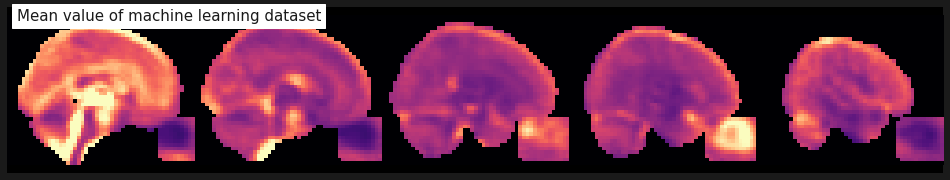

In [4]:
plot_anat(mean_img(func), cmap='magma', colorbar=False, display_mode='x', vmax=2, annotate=False,
          cut_coords=range(0, 49, 12), title='Mean value of machine learning dataset');

As a reminder, the shape of our machine learning dataset is as follows:

# Specifying labels and chunks

As in the `nilearn` and `PyMVPA` notebook, we need some chunks and label variables to train the neural network. The labels are important so that we can predict what we want to classify. And the chunks are just an easy way to make sure that the training and test dataset are split in an equal/balanced way.

So, as before, we specify again which volumes of the dataset were recorded during eyes **closed** resting state and which ones were recorded during eyes **open** resting state recording.

From the [Machine Learning Preparation](machine_learning_preparation.ipynb) notebook, we know that we have a total of 384 volumes in our `dataset_ML.nii.gz` file and that it's always 4 volumes of the condition `eyes closed`, followed by 4 volumes of the condition `eyes open`, etc. Therefore our labels should be as follows:

In [5]:
labels = np.ravel([[['closed'] * 4, ['open'] * 4] for i in range(48)])
labels[:20]

array(['closed', 'closed', 'closed', 'closed', 'open', 'open', 'open',
       'open', 'closed', 'closed', 'closed', 'closed', 'open', 'open',
       'open', 'open', 'closed', 'closed', 'closed', 'closed'],
      dtype='<U6')

***Second***, the `chunks` variable should not switch between subjects. So, as before, we can again specify 6 chunks of 64 volumes (8 subjects), each:

In [6]:
chunks = np.ravel([[i] * 64 for i in range(6)])
chunks[:150]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Keras - 2D Example

Convoluted neural networks are very powerful (as you will see), but the computation power to train the models can be incredibly demanding. For this reason, it's sometimes recommended to try to reduce the input space if possible.

In our case, we could try to not train the neural network only on one very thin slab (a few slices) of the brain. So, instead of taking the data matrix of the whole brain, we just take 2 slices in the region that we think is most likely to be predictive for the question at hand.

We know (or suspect) that the regions with the most predictive power are probably somewhere around the eyes and in the visual cortex. So let's try to specify a few slices that cover those regions.

So, let's try to just take a few slices around the eyes:

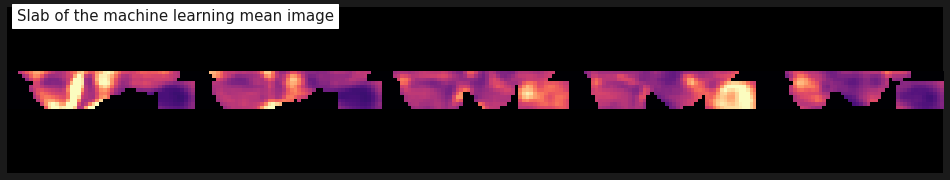

In [7]:
plot_anat(mean_img(func).slicer[...,5:-25], cmap='magma', colorbar=False,
          display_mode='x', vmax=2, annotate=False, cut_coords=range(0, 49, 12),
          title='Slab of the machine learning mean image');

Hmm... That doesn't seem to work. We want to cover the eyes and the visual cortex. Like this, we're too far down in the back of the head (at the Cerebellum). One solution to this is to rotate the volume.

So let's do that:

In [8]:
# Rotation parameters
phi = 0.35
cos = np.cos(phi)
sin = np.sin(phi)

# Compute rotation matrix around x-axis
rotation_affine = np.array([[1, 0, 0, 0],
                            [0, cos, -sin, 0],
                            [0, sin, cos, 0],
                            [0, 0, 0, 1]])
new_affine = rotation_affine.dot(func.affine)

In [9]:
# Rotate and resample image to new orientation
from nilearn.image import resample_img
new_img = nb.Nifti1Image(func.get_fdata(), new_affine)
img_rot = resample_img(new_img, func.affine, interpolation='continuous')

In [10]:
# Delete zero-only rows and columns
from nilearn.image import crop_img
img_crop = crop_img(img_rot)

Let's check if the rotation worked.

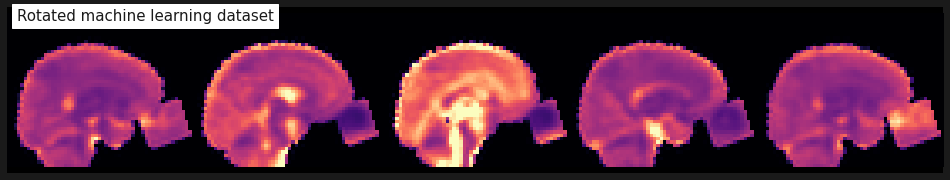

In [11]:
plot_anat(mean_img(img_crop), cmap='magma', colorbar=False, display_mode='x', vmax=2, annotate=False,
          cut_coords=range(-20, 30, 12), title='Rotated machine learning dataset');

Perfect! And which slab should we take? Let's try the slices 12, 13 and 14.

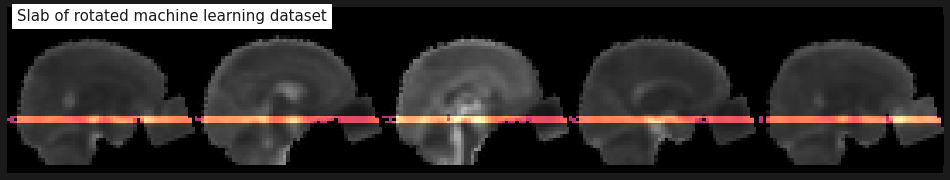

In [12]:
from nilearn.plotting import plot_stat_map
img_slab = img_crop.slicer[..., 12:15, :]
plot_stat_map(mean_img(img_slab), cmap='magma', bg_img=mean_img(img_crop), colorbar=False,
              display_mode='x', vmax=2, annotate=False, cut_coords=range(-20, 30, 12),
              title='Slab of rotated machine learning dataset');

Perfect, the slab seems to contain exactly what we want. Now that the data is ready we can continue with the actual machine learning part.

## Split data into a training and testing set

First things first, we need to define a training and testing set. This is *really* important because we need to make sure that our model can generalize to new, unseen data. Here, we randomly shuffle our data, and reserve 80% of it for our training data, and the remaining 20% for testing.

So let's first get the data in the right structure for keras. For this, we need to swap some of the dimensions of our data matrix.

In [13]:
data = np.rollaxis(img_slab.get_fdata(), 3, 0)
data.shape

(384, 40, 56, 3)

As you can see, the goal is to have in the first dimension, the different volumes, and then the volume itself. Keep in mind, that the last dimension (here of size 2), are considered as `channels` in the keras model that we will be using below.

**Note:** To make this notebook reproducible, i.e. always leading to the "same" results. Let's set a seed point for the random split of the dataset. This should only be done for teaching purposes, but not for real research as randomness and chance are a crucial part of machine learning.

In [14]:
from numpy.random import seed
seed(0)

As a next step, let's create a index list that we can use to split the data and labels into training and test sets:

In [15]:
# Create list of indices and shuffle them
N = data.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

#  Cut the dataset at 80% to create the training and test set
N_80p = int(0.8 * N)
indices_train = indices[:N_80p]
indices_test = indices[N_80p:]

# Split the data into training and test sets
X_train = data[indices_train, ...]
X_test = data[indices_test, ...]

print(X_train.shape, X_test.shape)

(307, 40, 56, 3) (77, 40, 56, 3)


## Create outcome variable

We need to define a variable that holds the outcome variable (1 or 0) that indicates whether or not the resting-state images were recorded with eyes opened or closed. Luckily we have this information already stored in the `labels` variable above. So let's split these labels in training and test set:

In [16]:
y_train = labels[indices_train] == 'open'
y_test = labels[indices_test] == 'open'

## Data Scaling

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [18]:
scaler = StandardScaler()
pca = PCA()
tsne = TSNE()

In [19]:
X_scaled = scaler.fit_transform(X_train.reshape(len(X_train), -1))

In [20]:
X_pca = pca.fit_transform(X_scaled)

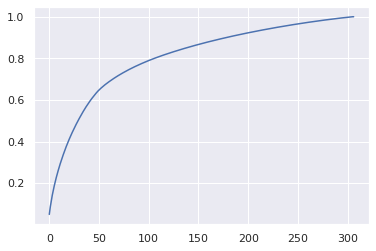

In [21]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [22]:
y_train

array([ True,  True,  True,  True, False, False,  True, False,  True,
        True, False, False, False, False,  True,  True,  True, False,
       False, False,  True, False, False, False, False,  True,  True,
        True, False,  True,  True, False,  True,  True, False, False,
        True,  True,  True,  True, False, False, False, False, False,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True, False, False, False,  True,  True,
       False, False, False,  True, False, False, False,  True,  True,
        True,  True, False,  True,  True, False, False, False, False,
       False,  True,  True,  True,  True, False,  True, False,  True,
        True, False, False,  True,  True,  True, False, False,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True, False,  True,  True,  True,
       False, False,  True,  True, False,  True, False, False, False,
        True, False,

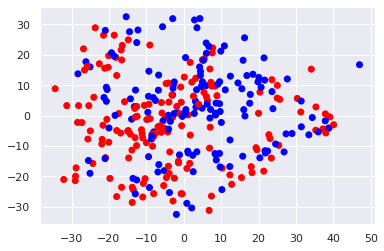

In [23]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='bwr')

In [24]:
X_tsne = tsne.fit_transform(X_pca)

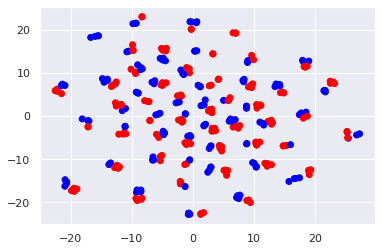

In [25]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='bwr')

In [26]:
mean = X_train.mean(axis=0)
mean.shape

(40, 56, 3)

In [27]:
std = X_train.std(axis=0)
std.shape

(40, 56, 3)

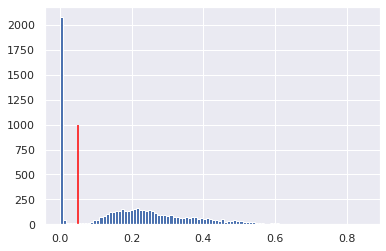

In [28]:
plt.hist(np.ravel(std), bins=100);
plt.vlines(0.05, 0, 1000, colors='red')

In [29]:
std[std<0.05] = 0

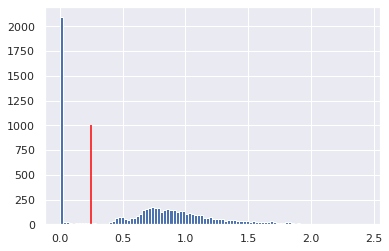

In [30]:
plt.hist(np.ravel(mean), bins=100);
plt.vlines(0.25, 0, 1000, colors='red')

In [31]:
mean[mean<0.05] = 0

In [32]:
mask = (mean*std)!=0

In [33]:
X_zscore_tr = (X_train-mean)/std
X_zscore_te = (X_test-mean)/std
X_zscore_tr.shape

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(307, 40, 56, 3)

In [34]:
X_zscore_tr[np.isnan(X_zscore_tr)]=0
X_zscore_te[np.isnan(X_zscore_te)]=0

In [35]:
X_zscore_tr[np.isinf(X_zscore_tr)]=0
X_zscore_te[np.isinf(X_zscore_te)]=0

And now we're good to go.

## Creating a Sequential Model

Now come the fun and tricky part. We need to specify the structure of our convoluted neural network. As a quick reminder, a convoluted neural network consists of some convolution layers, pooling layers, some flattening layers and some full connect layers:

<img src="https://www.pnas.org/content/pnas/116/4/1074/F2.large.jpg"/>

Taken from: [Waldrop 2019](https://www.pnas.org/content/116/4/1074)

So as a first step, let's import all modules that we need to create the keras model:

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD

As a next step, we should specify some of the model parameters that we want to be identical throughout the model:

In [37]:
# Get shape of input data
data_shape = tuple(X_train.shape[1:])

# Specify shape of convolution kernel
kernel_size = (3, 3)

# Specify number of output categories
n_classes = 2

Now comes the big part... the model, i.e. the structure of the neural network! We want to make clear that we're no experts in deep neural networks and therefore, the model below might not necessarily be a good model. But we chose it as it can be rather quickly estimated and has rather few parameters to estimate.

In [38]:
# Specify number of filters per layer
filters = 32

model = Sequential()

model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=data_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D())
filters *= 2

model.add(Conv2D(filters, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
filters *= 2

model.add(Conv2D(filters, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
filters *= 2

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', # swap out for sgd 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 54, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 54, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 27, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 25, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 25, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 12, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 10, 128)        7

That's what our model looks like! Cool!

## Fitting the Model

The next step is now, of course, to fit our model to the training data. In our case we have two parameters that we can work with:

*First*: How many iterations of the model fitting should be computed

In [39]:
nEpochs = 125  # Increase this value for better results (i.e., more training)

*Second*: How many elements (volumes) should be considered at once for the updating of the weights?

In [40]:
batch_size = 32   # Increasing this value might speed up fitting

So let's test the model:

In [41]:
%time fit = model.fit(X_zscore_tr, y_train, epochs=nEpochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/125
8/8 [==============================] - 2s 209ms/step - loss: 1.3661 - accuracy: 0.4857 - val_loss: 0.7003 - val_accuracy: 0.4355
Epoch 2/125
8/8 [==============================] - 1s 69ms/step - loss: 1.0531 - accuracy: 0.5796 - val_loss: 0.6746 - val_accuracy: 0.5968
Epoch 3/125
8/8 [==============================] - 1s 81ms/step - loss: 1.0525 - accuracy: 0.5959 - val_loss: 0.6374 - val_accuracy: 0.6935
Epoch 4/125
8/8 [==============================] - 1s 69ms/step - loss: 0.7713 - accuracy: 0.6898 - val_loss: 0.5978 - val_accuracy: 0.7419
Epoch 5/125
8/8 [==============================] - 1s 66ms/step - loss: 0.6390 - accuracy: 0.6816 - val_loss: 0.5960 - val_accuracy: 0.6935
Epoch 6/125
8/8 [==============================] - 1s 84ms/step - loss: 0.5382 - accuracy: 0.7347 - val_loss: 0.6074 - val_accuracy: 0.7097
Epoch 7/125
8/8 [==============================] - 1s 74ms/step - loss: 0.5092 - accuracy: 0.7714 - val_loss: 0.6396 - val_accuracy: 0.5968
Epoch 8/125
8/8 [==

8/8 [==============================] - 1s 69ms/step - loss: 0.0328 - accuracy: 0.9878 - val_loss: 0.3638 - val_accuracy: 0.8710
Epoch 60/125
8/8 [==============================] - 0s 58ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.3651 - val_accuracy: 0.8548
Epoch 61/125
8/8 [==============================] - 0s 61ms/step - loss: 0.0160 - accuracy: 0.9959 - val_loss: 0.4513 - val_accuracy: 0.8548
Epoch 62/125
8/8 [==============================] - 1s 63ms/step - loss: 0.0450 - accuracy: 0.9755 - val_loss: 0.4904 - val_accuracy: 0.8548
Epoch 63/125
8/8 [==============================] - 1s 65ms/step - loss: 0.0357 - accuracy: 0.9878 - val_loss: 0.5385 - val_accuracy: 0.8548
Epoch 64/125
8/8 [==============================] - 0s 60ms/step - loss: 0.0244 - accuracy: 0.9918 - val_loss: 0.5685 - val_accuracy: 0.8548
Epoch 65/125
8/8 [==============================] - 1s 72ms/step - loss: 0.0403 - accuracy: 0.9837 - val_loss: 0.4873 - val_accuracy: 0.8710
Epoch 66/125
8/8 [========

8/8 [==============================] - 1s 96ms/step - loss: 0.0230 - accuracy: 0.9837 - val_loss: 0.4116 - val_accuracy: 0.8710
Epoch 118/125
8/8 [==============================] - 1s 76ms/step - loss: 0.0124 - accuracy: 0.9959 - val_loss: 0.4965 - val_accuracy: 0.8387
Epoch 119/125
8/8 [==============================] - 1s 72ms/step - loss: 0.0134 - accuracy: 0.9959 - val_loss: 0.5153 - val_accuracy: 0.8387
Epoch 120/125
8/8 [==============================] - 1s 69ms/step - loss: 0.0094 - accuracy: 0.9959 - val_loss: 0.5226 - val_accuracy: 0.8387
Epoch 121/125
8/8 [==============================] - 1s 74ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.5218 - val_accuracy: 0.8548
Epoch 122/125
8/8 [==============================] - 1s 69ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.5120 - val_accuracy: 0.8548
Epoch 123/125
8/8 [==============================] - 1s 65ms/step - loss: 0.0165 - accuracy: 0.9959 - val_loss: 0.5102 - val_accuracy: 0.8548
Epoch 124/125
8/8 [=

## Performance during model fitting

Let's take a look at the loss and accuracy values during the different epochs:

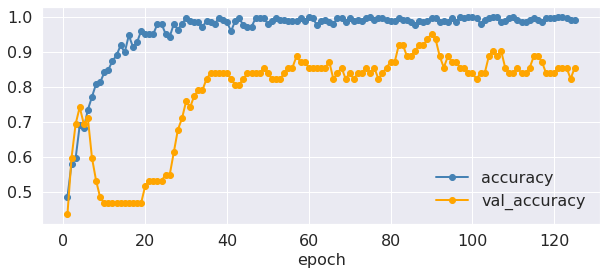

In [42]:
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(nEpochs) + 1
fontsize = 16
plt.plot(epoch, fit.history['accuracy'], marker="o", linewidth=2,
         color="steelblue", label="accuracy")
plt.plot(epoch, fit.history['val_accuracy'], marker="o", linewidth=2,
         color="orange", label="val_accuracy")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

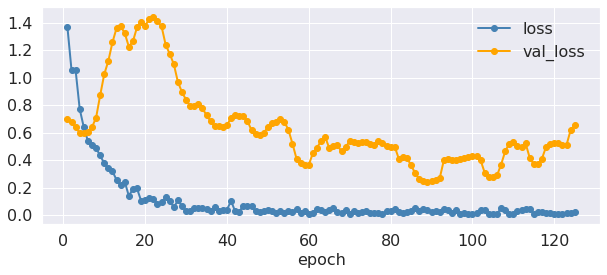

In [43]:
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(nEpochs) + 1
fontsize = 16
plt.plot(epoch, fit.history['loss'], marker="o", linewidth=2,
         color="steelblue", label="loss")
plt.plot(epoch, fit.history['val_loss'], marker="o", linewidth=2,
         color="orange", label="val_loss")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

Great, it seems that accuracy is constantly increasing and the loss is continuing to drop. But how well is our model doing on the test data?

## Evaluating the model

In [44]:
evaluation = model.evaluate(X_zscore_te, y_test)
print('Loss in Test set:      %.02f' % (evaluation[0]))
print('Accuracy in Test set:  %.02f' % (evaluation[1] * 100))

3/3 [==============================] - 0s 9ms/step - loss: 0.4645 - accuracy: 0.8571
Loss in Test set:      0.46
Accuracy in Test set:  85.71


# Confusion Matrix

In [45]:
y_pred = np.argmax(model.predict(X_zscore_te), axis=1)
y_pred

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1])

In [46]:
y_true = y_test * 1
y_true

array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1])

In [47]:
from sklearn.metrics import confusion_matrix
import pandas as pd

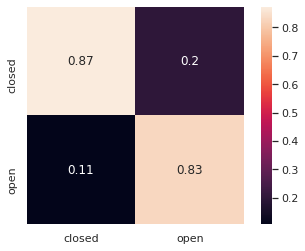

In [48]:
class_labels = ['closed', 'open']
cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=class_labels, columns=class_labels)
sns.heatmap(cm/cm.sum(axis=1), square=True, annot=True);

## Analyze prediction values

What are the predicted values of the test set?

In [49]:
y_pred = model.predict(X_zscore_te)
y_pred[:10,:]

array([[1.8052218e-04, 9.9981946e-01],
       [9.2166644e-01, 7.8333572e-02],
       [9.7517268e-06, 9.9999022e-01],
       [9.9997163e-01, 2.8365886e-05],
       [4.1778341e-05, 9.9995828e-01],
       [9.9945563e-01, 5.4433825e-04],
       [9.9174607e-01, 8.2539245e-03],
       [3.5141216e-05, 9.9996483e-01],
       [1.1560773e-01, 8.8439232e-01],
       [8.1596839e-01, 1.8403161e-01]], dtype=float32)

As you can see, those values can be between 0 and 1.

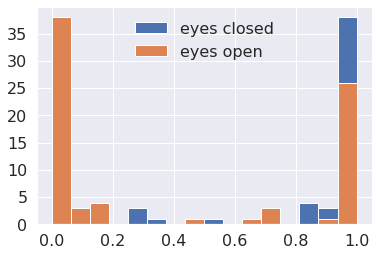

In [50]:
fig = plt.figure(figsize=(6, 4))
fontsize = 16
plt.hist(y_pred[:,0], bins=16, label='eyes closed')
plt.hist(y_pred[:,1], bins=16, label='eyes open');
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

The more both distributions are distributed around chance level, the weaker your model is.

**Note:** Keep in mind that we trained the whole model only on one split of test and training data. Ideally, you would repeat this process many times so that your results become less dependent on what kind of split you did.

## Visualizing Hidden Layers

Finally, as a cool additional feature: We can now visualize the individual filters of the hidden layers. So let's get to it:

In [51]:
# Aggregate the layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [52]:
from tensorflow.keras import backend as K

# Specify a function that visualized the layers
def show_activation(layer_name):
    
    layer_output = layer_dict[layer_name].output

    fn = K.function([model.input], [layer_output])
    
    inp = X_train[0:1]
    
    this_hidden = fn([inp])[0]
    
    # plot the activations, 8 filters per row
    plt.figure(figsize=(16,8))
    nFilters = this_hidden.shape[-1]
    nColumn = 8 if nFilters >= 8 else nFilters
    for i in range(nFilters):
        plt.subplot(nFilters / nColumn, nColumn, i+1)
        plt.imshow(this_hidden[0,:,:,i], cmap='magma', interpolation='nearest')
        plt.axis('off')
    
    return 

Now we can plot the filters of the hidden layers:

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


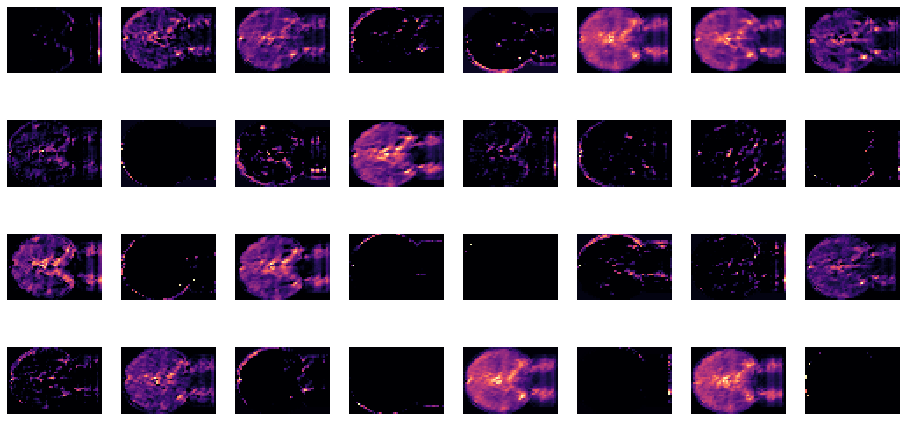

In [53]:
show_activation('conv2d')

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


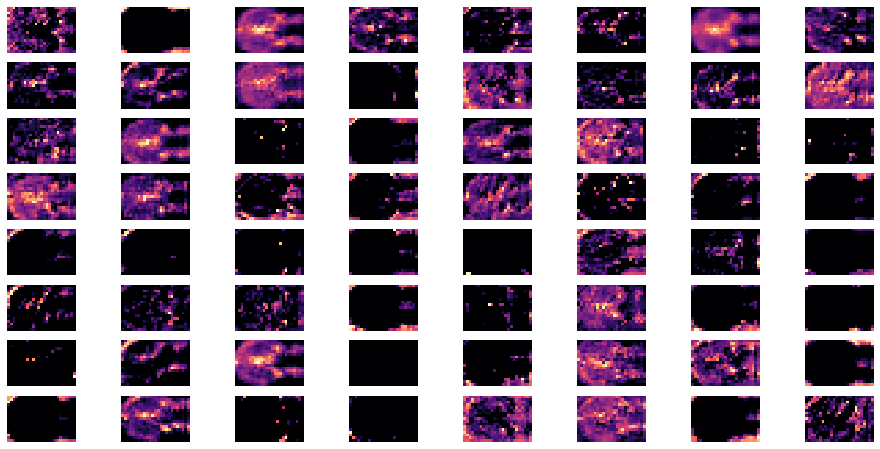

In [54]:
show_activation('conv2d_1')

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


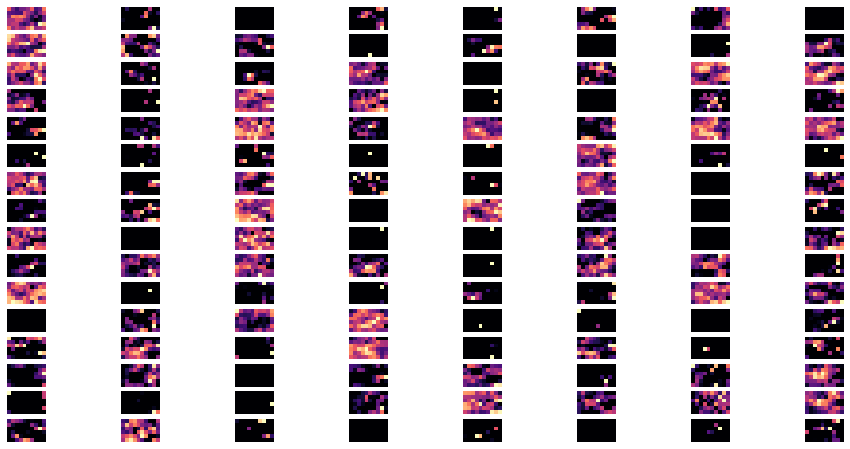

In [55]:
show_activation('conv2d_2')

## Conclusion of 2D example

The classification of the training set gets incredibly high, while the validation set also reaches a reasonable accuracy level above 80. Nonetheless, by only investigating a slab of our fMRI dataset, we might have missed out on some important additional parameters.

An alternative solution might be to use 3D convoluted neural networks. But keep in mind that they will have even more parameters and probably take much longer to fit the model to the training data. Having said so, let's get to it.